In [1]:
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program will plot the MET for events which have an opposite-sign muon pair that has mass in the range of 60-120 GeV.

class METMuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        muon_axis = hist.Bin("MET", "MET [GeV]", 50, 1, 100)
        
        self._accumulator = processor.dict_accumulator({
            'MET': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df["dataset"]
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content,
            eta=df['Muon_eta'].content,
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            charge=df['Muon_charge'].content
            )
        MET = df['MET_pt']
        
        output['cutflow']['all events'] += muons.size
        output['cutflow']['all muons'] += muons.mass.counts.sum()
        
        # Get all combinations of muon pairs in every event.
        dimuons = muons.distincts()
        output['cutflow']['all pairs'] += dimuons.mass.counts.sum()
        
        # Check that pairs have opposite charge.
        opposites = (dimuons.i0.charge != dimuons.i1.charge)
        
        # Get only muons with energy between 60 and 120.
        limits = (dimuons.mass > 60) & (dimuons.mass < 120)
        
        # Mask the dimuons with the opposites and the limits to get dimuons with opposite charge and mass between 60 and 120 GeV.
        good_dimuons = dimuons[opposites & limits]
        output['cutflow']['final pairs'] += good_dimuons.mass.counts.sum()
        
        # Mask the MET to get it only if an associated dimuon pair meeting the conditions exists.
        good_MET = MET[good_dimuons.counts >= 1]
        output['cutflow']['final events'] += good_MET.size
        
        output['MET'].fill(dataset=dataset, MET=good_MET.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'MET Masked by Muons': ["root://cmsxrootd.fnal.gov//store/mc/RunIISummer16NanoAODv4/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/50000/C9B654CF-0B51-4444-A177-479200DCC429.root"]}
output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=METMuonProcessor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4},
                                 chunksize = 500000)

Processing: 100%|██████████| 107/107 [29:31<00:00, 20.77s/items]


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (MET Masked by Muons) instance at 0x7fef441e2ef0>: [<matplotlib.collections.PolyCollection at 0x7fefc87a34e0>],
  'legend': <matplotlib.legend.Legend at 0x7fef44169ac8>})

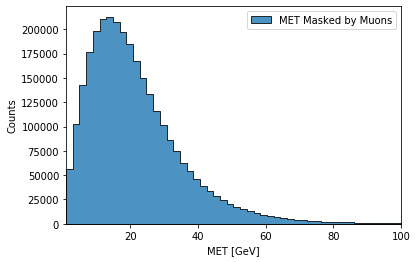

In [4]:
hist.plot1d(output['MET'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all muons 74439173
all pairs 31383312
final pairs 3176437
final events 2970891
